In [2]:
import time 
import numpy as np 
import pandas as pd
import os 
import pandas_ta as ta
import ccxt
from datetime import datetime
from xgboost import XGBRegressor  
import optuna 
from tqdm.auto import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 
from sklearn.preprocessing import MinMaxScaler
import sys
from sklearn.model_selection import train_test_split, TimeSeriesSplit
if not "Informer2020" in sys.path:
    sys.path += ["Informer2020"]
from Informer2020.models.model import Informer, InformerStack

import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("train.csv") 
submission = pd.read_csv("sample_submission.csv")

In [4]:
train['일시'] = pd.to_datetime(train['일시'])

train['month'] = train['일시'].dt.month
train['day'] = train['일시'].dt.day
train['weekday'] = train['일시'].dt.weekday

In [5]:
train = train[["month", "day", "weekday", "평균기온"]]

In [6]:
datetime_info = train[["month", "day", "weekday"]].values  
train = train.values

# preprocess data for informer 
window_size, target_size = 358, 358 
cur_enc_inputs, cur_dec_inputs, cur_targets, cur_enc_marks, cur_dec_marks = [], [], [], [], [] 
for i in tqdm(range(0, len(train) - window_size - target_size), position=0, leave=True, desc="data preprocessing"): 
    # time series input
    x = train[i:i+window_size, 3] 
    y = train[i+window_size:i+window_size+target_size, 3] 
    start_tokens = train[i:i+window_size, 3].reshape((-1, 1))
    y_0 = np.zeros((target_size, 1)) 
     
    cur_enc_inputs.append(x) 
    cur_dec_inputs.append(np.concatenate([start_tokens, y_0])) 
    cur_targets.append(y) 
    cur_enc_marks.append(datetime_info[i:i+window_size]) 
    cur_dec_marks.append(datetime_info[i:i+window_size+target_size]) 
    
cur_enc_inputs = torch.tensor(cur_enc_inputs).float() 
cur_dec_inputs = torch.tensor(cur_dec_inputs).float() 
cur_targets = torch.tensor(cur_targets).float() 
cur_enc_marks = torch.tensor(cur_enc_marks).float() 
cur_dec_marks = torch.tensor(cur_dec_marks).float() 

data preprocessing:   0%|          | 0/22295 [00:00<?, ?it/s]

In [7]:
cur_enc_inputs = torch.reshape(cur_enc_inputs, (-1, 358, 1))
cur_targets = torch.reshape(cur_targets, (-1, 358, 1))

cur_enc_inputs.shape, cur_dec_inputs.shape, cur_targets.shape, cur_enc_marks.shape, cur_dec_marks.shape

(torch.Size([22295, 358, 1]),
 torch.Size([22295, 716, 1]),
 torch.Size([22295, 358, 1]),
 torch.Size([22295, 358, 3]),
 torch.Size([22295, 716, 3]))

In [ ]:
tscv = TimeSeriesSplit(n_splits=5) 

for fold_idx, (train_index, val_index) in enumerate(tscv.split(cur_enc_inputs)):
    print(f"===== Iteration {fold_idx+1} =====")

    train_enc_inputs, val_enc_inputs = cur_enc_inputs[train_index], cur_enc_inputs[val_index] 
    train_dec_inputs, val_dec_inputs = cur_dec_inputs[train_index], cur_dec_inputs[val_index] 
    train_targets, val_targets = cur_targets[train_index], cur_targets[val_index] 
    train_enc_marks, val_enc_marks = cur_enc_marks[train_index], cur_enc_marks[val_index] 
    train_dec_marks, val_dec_marks = cur_dec_marks[train_index], cur_dec_marks[val_index] 
    
    batch_size = 32
    train_data = TensorDataset(train_enc_inputs, train_dec_inputs, train_targets, train_enc_marks, train_dec_marks)
    train_sampler = RandomSampler(train_data) 
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    val_data = TensorDataset(val_enc_inputs, val_dec_inputs, val_targets, val_enc_marks, val_dec_marks) 
    val_sampler = SequentialSampler(val_data) 
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
    
    best_val_loss = np.inf 
    device = torch.device("cuda") 
    model = InformerStack(enc_in=1, dec_in=1, c_out=1, seq_len=358, label_len=358, out_len=358, freq="D") 
    model.to(device) 
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) 
    loss_func = torch.nn.L1Loss() 
    epochs = 20 
    model.train() 
    model.zero_grad() 
    for epoch in tqdm(range(epochs), position=0, leave=True, desc="Epochs"): 
        model.train() 
        train_loss = 0 
        for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="training"): 
            batch = (t.to(device) for t in batch) 
            enc_inputs, dec_inputs, targets, enc_marks, dec_marks = batch 
            output = model(x_enc=enc_inputs, x_mark_enc=enc_marks, x_dec=dec_inputs, x_mark_dec=dec_marks) 
            loss = loss_func(output, targets) 
            train_loss += loss.item() 
            loss.backward() 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            optimizer.step() 
            model.zero_grad() 
        model.eval() 
        val_loss = 0 
        for batch in tqdm(val_dataloader, total=len(val_dataloader), desc="validating"): 
            batch = (t.to(device) for t in batch) 
            enc_inputs, dec_inputs, targets, enc_marks, dec_marks = batch 
            with torch.no_grad(): 
                outputs = model(x_enc=enc_inputs, x_mark_enc=enc_marks, x_dec=dec_inputs, x_mark_dec=dec_marks) 
                loss = loss_func(outputs, targets) 
                val_loss += loss.item() 
        avg_train_loss = train_loss / len(train_dataloader) 
        avg_val_loss = val_loss / len(val_dataloader) 
        print(f"epoch:{epoch} | train loss: {avg_train_loss} | val loss: {avg_val_loss}") 
        if best_val_loss > avg_val_loss:
            best_val_loss = avg_val_loss 
            torch.save(model.state_dict(), f"Informer_v1_fold_{fold_idx+1}.pt")

===== Iteration 1 =====


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:0 | train loss: 6.0633895050766125 | val loss: 3.970783201038328


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:1 | train loss: 3.269674833004291 | val loss: 2.900413073026217


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:2 | train loss: 2.62802075728392 | val loss: 2.9219895244663596


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:3 | train loss: 2.5074085700206266 | val loss: 3.1830216045053596


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:4 | train loss: 2.3992253633645864 | val loss: 2.976684953412439


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:5 | train loss: 2.3530742408882857 | val loss: 2.8021672220311613


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:6 | train loss: 2.2707985221830187 | val loss: 2.8336006555801783


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:7 | train loss: 2.2259244470514803 | val loss: 2.8618650253002462


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:8 | train loss: 2.194364337839632 | val loss: 2.8327758495624247


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:9 | train loss: 2.167299107608632 | val loss: 2.8993814745519915


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:10 | train loss: 2.1125522108159513 | val loss: 2.847532429246821


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:11 | train loss: 2.0783802301455765 | val loss: 2.8990762091090536


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:12 | train loss: 2.0717541366560845 | val loss: 2.8615443747267766


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:13 | train loss: 2.068901544962174 | val loss: 2.9232855413714027


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:14 | train loss: 2.037954525050954 | val loss: 2.936193837059869


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:15 | train loss: 2.0349054519946757 | val loss: 2.891747725315583


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:16 | train loss: 1.9978099990094829 | val loss: 2.9581252672733407


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:17 | train loss: 1.9924619707286868 | val loss: 2.876837229117369


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:18 | train loss: 1.9872543312545516 | val loss: 2.9227733958480706


training:   0%|          | 0/117 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:19 | train loss: 1.9918261236614652 | val loss: 2.94213785065545
===== Iteration 2 =====


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:0 | train loss: 4.632453420131503 | val loss: 3.1844970772409034


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:1 | train loss: 2.6649605409270194 | val loss: 2.9535624654884014


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:2 | train loss: 2.484172976579789 | val loss: 2.7460621687082143


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:3 | train loss: 2.364776501839765 | val loss: 2.7842077516083026


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:4 | train loss: 2.282302300817465 | val loss: 2.8601909519260764


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:5 | train loss: 2.234621869647963 | val loss: 2.814796127824702


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:6 | train loss: 2.1813986240026777 | val loss: 2.9694476494422326


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:7 | train loss: 2.15177192810779 | val loss: 2.7137563187851863


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:8 | train loss: 2.1012612074741477 | val loss: 2.851263565894885


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:9 | train loss: 2.083045500542473 | val loss: 2.7668637128976674


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:10 | train loss: 2.056410872885086 | val loss: 2.7662315694694843


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:11 | train loss: 2.031250965953385 | val loss: 2.7596912924041095


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:12 | train loss: 2.0190640498640198 | val loss: 2.761070828152518


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:13 | train loss: 1.9871337035183232 | val loss: 2.7497798948206453


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:14 | train loss: 1.9901754277970147 | val loss: 2.712185625337128


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:15 | train loss: 1.9563812222091936 | val loss: 2.8034424170469627


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:16 | train loss: 1.9418460110226414 | val loss: 2.7558173236683903


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:17 | train loss: 1.9362433729253614 | val loss: 2.718745453744872


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:18 | train loss: 1.919914368907781 | val loss: 2.7805596050034223


training:   0%|          | 0/233 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:19 | train loss: 1.9140371196771384 | val loss: 2.7392233233166556
===== Iteration 3 =====


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:0 | train loss: 3.938046572201573 | val loss: 2.8309553912562184


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:1 | train loss: 2.516340581598801 | val loss: 2.6400237063057403


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:2 | train loss: 2.3646505951539836 | val loss: 2.6108074453141956


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:3 | train loss: 2.2544489439715627 | val loss: 2.64295883056445


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:4 | train loss: 2.1935701745970544 | val loss: 2.6341695989299025


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:5 | train loss: 2.14927805323997 | val loss: 2.6137007811130624


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:6 | train loss: 2.0969475968860967 | val loss: 2.664184364498171


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:7 | train loss: 2.057000644569069 | val loss: 2.6689368343760824


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:8 | train loss: 2.0259994893497586 | val loss: 2.675962093548897


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:9 | train loss: 1.996796779782861 | val loss: 2.7716137089281


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:10 | train loss: 1.9722613697407239 | val loss: 2.6350664348683805


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:11 | train loss: 1.954014147250222 | val loss: 2.660988877981137


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:12 | train loss: 1.9322266886090822 | val loss: 2.689514470915509


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:13 | train loss: 1.9012076390165313 | val loss: 2.696344679237431


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:14 | train loss: 1.8987408463114654 | val loss: 2.7452143624297576


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:15 | train loss: 1.8740593406737363 | val loss: 2.736411730448405


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:16 | train loss: 1.866293790347255 | val loss: 2.78064928503118


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:17 | train loss: 1.8464285306056112 | val loss: 2.782440812159807


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:18 | train loss: 1.8326617127503229 | val loss: 2.778105084712689


training:   0%|          | 0/349 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:19 | train loss: 1.817288669610775 | val loss: 2.7724213355626817
===== Iteration 4 =====


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

training:   0%|          | 0/465 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:0 | train loss: 3.6161886456192183 | val loss: 2.7594169266203528


training:   0%|          | 0/465 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:1 | train loss: 2.479187951549407 | val loss: 2.6258616855001855


training:   0%|          | 0/465 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:2 | train loss: 2.3242273002542477 | val loss: 2.6631241150391407


training:   0%|          | 0/465 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:3 | train loss: 2.2273324694684757 | val loss: 2.7494555212493634


training:   0%|          | 0/465 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:4 | train loss: 2.1520001231983144 | val loss: 2.6836088579944057


training:   0%|          | 0/465 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:5 | train loss: 2.0915780200753162 | val loss: 2.7099507079165206


training:   0%|          | 0/465 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:6 | train loss: 2.040970107816881 | val loss: 2.729912541870378


training:   0%|          | 0/465 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:7 | train loss: 2.010181204221582 | val loss: 2.7811877625620265


training:   0%|          | 0/465 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:8 | train loss: 1.9795400050378615 | val loss: 2.7396755198128204


training:   0%|          | 0/465 [00:00<?, ?it/s]

validating:   0%|          | 0/117 [00:00<?, ?it/s]

epoch:9 | train loss: 1.952480891699432 | val loss: 2.771837503482134


training:   0%|          | 0/465 [00:00<?, ?it/s]

In [8]:
# inference 
informer_fold5_chkpt = torch.load("Informer_v1_fold_5.pt")
informer5 = InformerStack(enc_in=1, dec_in=1, c_out=1, seq_len=358, label_len=358, out_len=358, freq="D")  
informer5.load_state_dict(informer_fold5_chkpt)

<All keys matched successfully>

In [9]:
train = pd.read_csv("train.csv") 
submission = pd.read_csv("sample_submission.csv")

train['일시'] = pd.to_datetime(train['일시'])

train['month'] = train['일시'].dt.month
train['day'] = train['일시'].dt.day
train['weekday'] = train['일시'].dt.weekday

train = train[["month", "day", "weekday", "평균기온"]]

datetime_info = train[["month", "day", "weekday"]].values  
train = train.values

In [10]:
test_input = train[-358:, 3] 
test_datetime = datetime_info[-358:, :] 

In [11]:
submission['일시'] = pd.to_datetime(submission['일시']) 
submission['month'] = submission['일시'].dt.month
submission['day'] = submission['일시'].dt.day
submission['weekday'] = submission['일시'].dt.weekday

submission.head()

,일시,평균기온,month,day,weekday
0,2023-01-01,0,1,1,6
1,2023-01-02,0,1,2,0
2,2023-01-03,0,1,3,1
3,2023-01-04,0,1,4,2
4,2023-01-05,0,1,5,3


In [12]:
submission.shape

(358, 5)

In [13]:
cur_enc_inputs = test_input

start_tokens = test_input.reshape((-1, 1))
y_0 = np.zeros((target_size, 1)) 
cur_dec_inputs = np.concatenate([start_tokens, y_0])

cur_enc_marks = test_datetime

cur_dec_marks = np.concatenate([test_datetime, submission[["month", "day", "weekday"]].values])

In [16]:
cur_enc_inputs = torch.tensor(cur_enc_inputs).float() 
cur_enc_inputs = torch.reshape(cur_enc_inputs, (-1, 358, 1)) 

cur_dec_inputs = torch.tensor(cur_dec_inputs).float() 
cur_dec_inputs = torch.reshape(cur_dec_inputs, (-1, 716, 1))

cur_enc_marks = torch.tensor(cur_enc_marks).float() 
cur_enc_marks = torch.reshape(cur_enc_marks, (-1, 358, 3))

cur_dec_marks = torch.tensor(cur_dec_marks).float() 
cur_dec_marks = torch.reshape(cur_dec_marks, (-1, 716, 3))

cur_enc_inputs.shape, cur_dec_inputs.shape, cur_enc_marks.shape, cur_dec_marks.shape

(torch.Size([1, 358, 1]),
 torch.Size([1, 716, 1]),
 torch.Size([1, 358, 3]),
 torch.Size([1, 716, 3]))

In [17]:
informer5.eval() 
with torch.no_grad(): 
    output = informer5(x_enc=cur_enc_inputs, x_mark_enc=cur_enc_marks, x_dec=cur_dec_inputs, x_mark_dec=cur_dec_marks)

In [19]:
output = output.detach().cpu().numpy() 

In [20]:
output.shape

(1, 358, 1)

In [21]:
output = output.reshape((358))

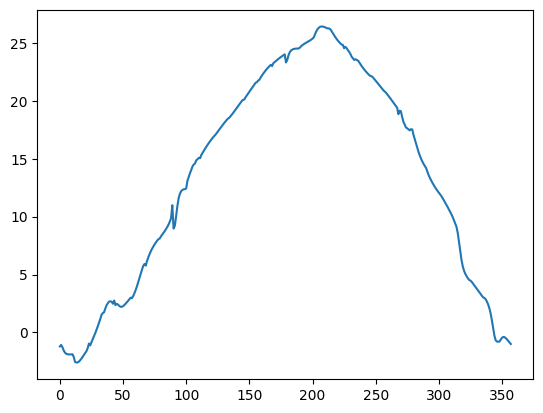

In [23]:
plt.plot(output)

In [24]:
informer_ans = pd.read_csv("sample_submission.csv") 

informer_ans["평균기온"] = 

,일시,평균기온
0,2023-01-01,0
1,2023-01-02,0
2,2023-01-03,0
3,2023-01-04,0
4,2023-01-05,0
...,...,...
353,2023-12-20,0
354,2023-12-21,0
355,2023-12-22,0
356,2023-12-23,0
